In [1]:
import jax
from jax import numpy as jnp
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses
import copy
import waymax

from scipy.interpolate import splprep, splev
from waymax import config as _config
from waymax import dataloader
from waymax import metrics
from waymax import datatypes
from waymax import dynamics
from waymax import env as _env
from waymax import agents
from waymax import visualization
from waymax.agents import actor_core
from waymax.dynamics.tricycle_model import TricycleModel
from waymax import utils
from waymax.utils.gokart_utils import create_init_state, create_batch_init_state, generate_racing_track
from waymax.utils.gokart_config  import GoKartGeometry, TrackControlPoints, TricycleParams, PajieckaParams
print(waymax.utils.gokart_config.__file__)

d:\waymax\waymax\utils\gokart_config.py


In [4]:
# test the track generation function
track_controlpoints = TrackControlPoints()
_, x_center, y_center, cumulative_length = generate_racing_track(track_controlpoints.x, track_controlpoints.y, track_controlpoints.r)
print(x_center[0],y_center[0]) # the first point is also the last point
print(x_center[-1],y_center[-1])
print(x_center[-2],y_center[-2])
distance = jnp.sqrt((x_center[1:]-x_center[:-1])**2+(y_center[1:]-y_center[:-1])**2)  # distance between two centerline points
print(distance[:20])
print(x_center.shape, cumulative_length.shape)
print(cumulative_length[0])
print(cumulative_length[-1])

30.3914 20.1282
30.2988 20.129833
30.20623 20.131582
[0.09264261 0.09267307 0.09270182 0.09273077 0.09275798 0.09278729
 0.09281297 0.09284069 0.09286666 0.09289279 0.09291904 0.0929435
 0.09296809 0.09299089 0.09301569 0.09303868 0.09306175 0.09308302
 0.09310243 0.09312573]
(2000,) (2000,)
0.0
187.7237830483307


In [5]:
state_batch = create_batch_init_state()
state_batch.timestep[0].shape

()

In [6]:
print(state_batch.log_trajectory.xy[0,0,0])
print(state_batch.log_trajectory.xy[0,0,1])
print(state_batch.log_trajectory.xy[0,0,-1])
print(state_batch.sim_trajectory.xy[0,0,0])
print(state_batch.sim_trajectory.xy[0,0,1])
print(state_batch.sim_trajectory.xy[0,0,-1])
state_batch.validate()

[30.3914 20.1282]
[0. 0.]
[30.2988   20.129833]
[30.3914 20.1282]
[0. 0.]
[0. 0.]


In [2]:
viz_cfg={
  "front_x": 20.0,
  "back_x":  20.0,
  "front_y":  20.0,
  "back_y": 20.0,
  "px_per_meter": 15.0
}

In [11]:
state = create_batch_init_state(num_timesteps=200)

# img=visualization.plot_simulator_state(state, use_log_traj=False, batch_idx=0 ,viz_config=viz_cfg)
# mediapy.show_image(img)
dummy_action = actor_core.WaymaxActorOutput(actor_state=None, 
                                     action = datatypes.Action(data=jnp.array([[0.5, 0.2, 0.2],[0., 0.2, 0.2]]), valid=jnp.array([[True],[True]])), 
                                     is_controlled=jnp.array([[True],[True]]))
print(dummy_action.action.valid.shape)

(2, 1)


In [12]:
state_batch = create_batch_init_state()
dummy_action = actor_core.WaymaxActorOutput(actor_state=None, 
                                    action = datatypes.Action(data=jnp.array([[0., 0.2, 0.2],[0., 0., 0.]]), valid=jnp.array([[True],[True]])), 
                                    is_controlled=jnp.array([[True],[True]]))

dynamics_model = TricycleModel(gk_geometry=GoKartGeometry(), model_params=TricycleParams(), paj_params=PajieckaParams())
env1 = _env.PlanningAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        max_num_objects=1,
        init_steps = 1  # state.timestep = 0
    ),
)
# jit_step = jax.jit(env1.step)
state_batch = env1.reset(state_batch)
next_state_batch = env1.step(state_batch, action = dummy_action.action)

In [13]:
print(state_batch.sim_trajectory.xy[1,0,:3])
print(next_state_batch.sim_trajectory.xy[1,0,:3])

[[30.3914 20.1282]
 [-1.     -1.    ]
 [-1.     -1.    ]]
[[30.3914 20.1282]
 [30.3914 20.1282]
 [-1.     -1.    ]]


""

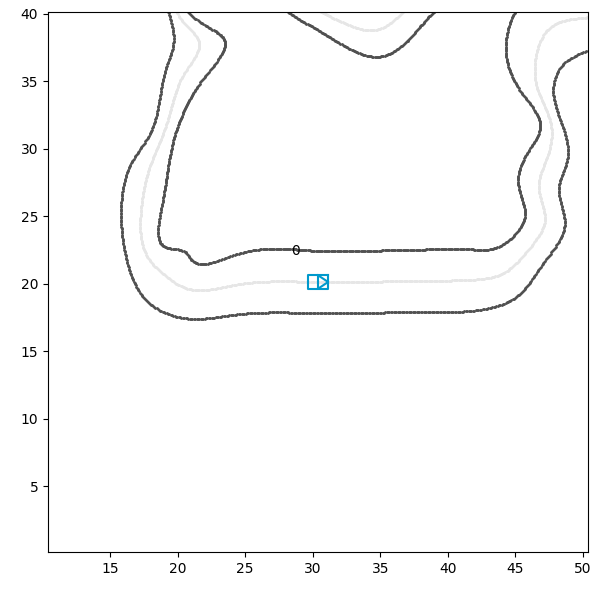

In [3]:
state = create_init_state(num_timesteps=100)
# test the state object
# print(state.sdc_paths.xy[0,:10])
# print(state.sim_trajectory.valid)
# print(state.sim_trajectory.xy[0,:10])
img=visualization.plot_simulator_state(state, use_log_traj=False, viz_config=viz_cfg)
mediapy.show_image(img)

In [4]:
# for multiagent env
# dummy_action = actor_core.WaymaxActorOutput(actor_state=None, 
#                                      action = datatypes.Action(data=jnp.array([[0.0, 0.2, 0.2]]), valid=jnp.array([[True]])), 
#                                      is_controlled=jnp.array([True]))

# for planning agent env
dummy_action = actor_core.WaymaxActorOutput(actor_state=None, 
                                     action = datatypes.Action(data=jnp.array([0.0, -1, -1.]), valid=jnp.array([True])), 
                                     is_controlled=jnp.array([True]))

In [5]:
# dynamics_model = dynamics.StateDynamics()
dynamics_model = TricycleModel(gk_geometry=GoKartGeometry(), model_params=TricycleParams(), paj_params=PajieckaParams(), dt=0.1)

# Expect users to control all valid object in the scene.
# env = _env.MultiAgentEnvironment(
#     dynamics_model=dynamics_model,
#     config=dataclasses.replace(
#         _config.EnvironmentConfig(),
#         max_num_objects=1,
#         init_steps = 1
#     ),
# )

env1 = _env.GokartRacingEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        max_num_objects=1,
        init_steps = 1  # => state.timestep = 0
    ),
)

In [17]:
# dynamics_model = dynamics.StateDynamics()
# actor = agents.create_constant_speed_actor(
#     speed=2.0,
#     dynamics_model=dynamics_model,
#     is_controlled_func=lambda state: jnp.array([True]),
# )

In [6]:

jit_step = jax.jit(env1.step)

# jit_select_action = jax.jit(actor.select_action)

""

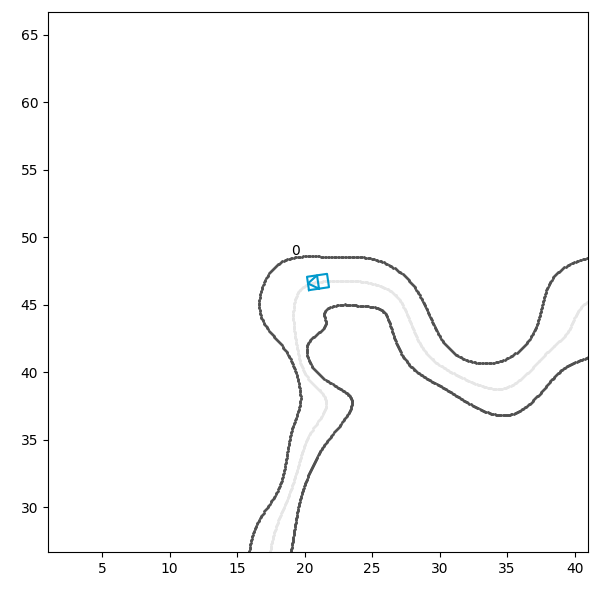

In [7]:
rng = jax.random.PRNGKey(3)
_ , state = env1.reset(state, rng)
img=visualization.plot_simulator_state(state, use_log_traj=False, viz_config=viz_cfg)
mediapy.show_image(img)

In [29]:
last_state = state
obs, state, reward, done, info = jit_step(state, action = dummy_action.action)
print(obs)
print(reward)
print(state.current_sim_trajectory.xy)
print(done)
print(info)

[ 2.9581400e+01  2.0128201e+01  0.0000000e+00 -1.8000002e+00
  0.0000000e+00  2.3976913e-02  2.2828274e+00  2.5199831e+00
  3.5888267e+00  9.3958197e+00  1.0443141e+01  3.4749134e+00
  2.4856820e+00  2.3402557e+00  5.8766454e-07]
-0.384906
[[[29.5814 20.1282]]]
False
{}


In [18]:
dir_ref = env1.get_ref_direction(state)
progression_reward = env1._compute_progression_reward(last_state, state)
orientation_reward = env1._compute_orientation_reward(state, dir_ref)
print(f"vel: {state.current_sim_trajectory.vel_xy[0, 0, :]}")
print(dir_ref)
print(progression_reward)
print(orientation_reward)

vel: [1.8000002 0.       ]
[ 0.9999884  -0.00482521]
0.18570757
0.2


In [319]:
_, state = env1.reset(state)
states = [state]
metrics_list = []

for i in range(states[0].remaining_timesteps):
  current_state = states[-1]

  # action = jit_select_action({}, current_state, None, None)

  next_state = jit_step(current_state, action = dummy_action.action)
  # metric_dict = metrics.run_metrics(next_state, metrics_config)

  states.append(next_state)
  # metrics_list.append(metric_dict)

In [320]:
len(states)

200

In [321]:
# test the observation function
print(env1.observe(states[50])) # use normalized observation??   velocity in local frame

[1.9085417  0.0751408  0.9172847  0.07395168 0.12024864 0.14272887
 0.13693991 0.02744962 0.05051263 0.06506186 0.06589742]


In [322]:
# test metrics/rewards calculation
metrics_config = dataclasses.replace(_config.MetricsConfig(),metrics_to_run=("offroad", "sdc_progression"))
metric_dict1 = metrics.run_metrics(states[50], metrics_config)
print(states[-1].sim_trajectory.xy[0,50])
metric_dict2 = metrics.run_metrics(states[90], metrics_config)
print(states[-1].sim_trajectory.xy[0,90])

print(metric_dict1)
print(metric_dict2)

## what happens if the car start a new lap : reset the state

[34.48439  22.399818]
[32.20394 29.26053]
{'offroad': MetricResult(value=Array([1.], dtype=float32), valid=Array([ True], dtype=bool)), 'sdc_progression': MetricResult(value=Array(0.02333246, dtype=float32), valid=Array(True, dtype=bool))}
{'offroad': MetricResult(value=Array([1.], dtype=float32), valid=Array([ True], dtype=bool)), 'sdc_progression': MetricResult(value=Array(0.0105793, dtype=float32), valid=Array(True, dtype=bool))}


In [323]:
print(states[1].log_trajectory.shape)
print(states[-1].log_trajectory.xy[0,:3])
print(states[-1].log_trajectory.xy[0,-1])
print(states[-1].log_trajectory.valid[0,-1]) # check if the last log point should be valid??
print(states[-1].sim_trajectory.vel_xy[0,130:140])

(1, 200)
[[30.3914 20.1282]
 [ 0.      0.    ]
 [ 0.      0.    ]]
[0. 0.]
False
[[-1.2414018  -3.280484  ]
 [-1.1255374  -3.4279473 ]
 [-0.9935027  -3.577093  ]
 [-0.8441399  -3.726526  ]
 [-0.6763247  -3.874626  ]
 [-0.48899746 -4.0017896 ]
 [-0.26467323 -4.036374  ]
 [ 0.00543306 -4.06175   ]
 [ 0.32112262 -4.069514  ]
 [ 0.675808   -4.025909  ]]


In [324]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False,viz_config=viz_cfg))
# imgs = [visualization.plot_simulator_state(states[0], use_log_traj=False)]
# print(states[0].object_metadata)
mediapy.show_video(imgs, fps=10)

In [325]:
# similar setup for multiagent env

def create_init_state_2agents():
    trajectory = datatypes.GoKartTrajectory.zeros((2, 100))  # 2 object, 100 time steps
    sim_trajectory = trajectory
    sim_trajectory.length = jnp.ones_like(sim_trajectory.length) * 1.5
    sim_trajectory.width = jnp.ones_like(sim_trajectory.width)
    sim_trajectory.height = jnp.ones_like(sim_trajectory.height)
    sim_trajectory.valid = sim_trajectory.valid.at[:,0].set(True)
    # sim_trajectory.valid = jnp.ones_like(sim_trajectory.valid, dtype=jnp.bool_)
    sim_trajectory.x = sim_trajectory.x.at[0, 0].set(TrackControlPoints.x[0])
    sim_trajectory.y = sim_trajectory.y.at[0, 0].set(TrackControlPoints.y[0])
    sim_trajectory.x = sim_trajectory.x.at[1, 0].set(TrackControlPoints.x[-1])
    sim_trajectory.y = sim_trajectory.y.at[1, 0].set(TrackControlPoints.y[-1])
    traffic_light = datatypes.TrafficLights(x=jnp.zeros((0, 100)), y=jnp.zeros((0, 100)), z = jnp.zeros((0, 100)), 
                                            state=jnp.zeros((0, 100)), lane_ids=jnp.zeros((0, 100), dtype=jnp.int32), valid=jnp.ones((0, 100), dtype=jnp.bool_))
    metadata = datatypes.ObjectMetadata(ids=jnp.array([0, 1]), object_types=jnp.array([1]), is_sdc=jnp.array([True, False]), is_modeled=jnp.array([False, False]), 
                                        is_valid=jnp.array([True, True]), objects_of_interest=jnp.array([False, False]), is_controlled=jnp.array([True, False]))
    timestep = jnp.array(0, dtype=jnp.int32)
    num_points = 1000
    roadgraph_points, x_center, y_center, cumulative_length = generate_racing_track(TrackControlPoints.x, TrackControlPoints.y, TrackControlPoints.r, num_points=1000)

    dx_path = jnp.diff(x_center)
    dy_path = jnp.diff(y_center)
    dx_path = jnp.append(dx_path, dx_path[-1])
    dy_path = jnp.append(dy_path, dy_path[-1])
    dx_path /= jnp.sqrt(dx_path**2 + dy_path**2)
    dy_path /= jnp.sqrt(dx_path**2 + dy_path**2)
    dx_path = jnp.expand_dims(dx_path, axis=-2)
    dy_path = jnp.expand_dims(dy_path, axis=-2)
    x_path = jnp.expand_dims(x_center, axis=-2) 
    y_path = jnp.expand_dims(y_center, axis=-2)
    
    sdc_path = datatypes.GoKartPaths(
        x = x_path, # shape(num_paths=1, num_points_per_path)
        y = y_path,
        z = jnp.zeros_like(x_path),
        dir_x = dx_path,
        dir_y = dy_path,
        ids = jnp.zeros_like(x_path, dtype=jnp.int32),
        valid=jnp.ones_like(x_path, dtype=jnp.bool_),
        arc_length= jnp.expand_dims(cumulative_length, axis=(-2,-3)),
        on_route=jnp.ones((1, 1), dtype=jnp.bool_) # shape (num_paths=1, 1) 
    )

    log_trajectory = copy.deepcopy(sim_trajectory)
    log_trajectory.x = log_trajectory.x.at[0, -1].set(x_center[-1])
    log_trajectory.y = log_trajectory.y.at[0, -1].set(y_center[-1])


    return datatypes.GoKartSimState(sim_trajectory=sim_trajectory,log_trajectory=trajectory, log_traffic_light=traffic_light, 
                                    sdc_paths=sdc_path, object_metadata=metadata, timestep=timestep, roadgraph_points=roadgraph_points)

In [326]:
static_agent = [agents.FrozenSimPolicy(is_controlled_func=lambda state: jnp.array([False, True]))] # the second object is controlled by this agent
static_agent_param = [jnp.empty((1,))] # placeholder

In [327]:
env2 = _env.PlanningAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        max_num_objects = 2,
        init_steps = 1  # equal to state.timestep = 0
    ),
    sim_agent_actors=static_agent,
    sim_agent_params=static_agent_param
)

In [328]:
state2 = create_init_state_2agents()
jit_step = jax.jit(env2.step)
states = [env2.reset(state2)]

In [329]:
for _ in range(states[0].remaining_timesteps):
  current_state = states[-1]

  # action = jit_select_action({}, current_state, None, None)
  
  next_state = jit_step(current_state, action = dummy_action.action)

  states.append(next_state)

In [330]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False,viz_config=viz_cfg))
# imgs = [visualization.plot_simulator_state(states[0], use_log_traj=False)]
# print(states[0].object_metadata)
mediapy.show_video(imgs, fps=10)